<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum State Tomography*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q experience (QX), consult the [IBM Q experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Christopher J. Wood, Jay M. Gambetta

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum state tomography using QISKit, and demonstrate this using both simulators, and the IBM Quantum Experience. 

The functions used in this notebook to implement state tomography may be imported from the `tools.tomography` module.

#### Experiment Design

The tomography experiments demonstrated in this notebook append a state preparation circuit with to perform measurements of all qubits in each of the X, Y, and Z Pauli bases. For $n$-qubits this gives a total of $3^n$ measurement circuits which must be run, and the resulting counts for the $6^n$ measurement outcomes accross all circuits give a tomographically overcomplete basis for reconstruction of the quantum state.

#### State Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook implement two simple cases, they are: 
* Linear Inversion
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
import numpy as np
    
# importing the QISKit
sys.path.append("../../")
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import tomography libary
import tools.tomography as tomo

# useful additional packages 
from tools.vizualization import plot_state, plot_histogram
from tools.qi import state_fidelity, concurrence, purity

## State tomography of an entangled Bell-state

We will demonstrate preparation, measurement, and tomographic reconstruction of a 2-qubit Bell state $\frac{1}{\sqrt2}\left(|00\rangle+|11\rangle\right)$.

### State preparation

We begin with constructing a circuit to prepare the target state, this circuit requires a 2-qubit quantum register, and a 2-bit classical register to store measurement outcomes.

In [2]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
qr = Q_program.create_quantum_register("qr", 2)
cr = Q_program.create_classical_register("cr", 2)

# quantum circuit to make an entangled bell state 
bell = Q_program.create_circuit("bell", [qr], [cr])
bell.h(qr[0])
bell.cx(qr[0], qr[1])

#### Visualization of the ideal state

Before we perform tomographic measurement, lets visualize the ideal output state from the preparation circuit. We may do this by executing the circuit on the `local_qasm_simulator` backend. Since this is a simulation, it gives us direct access to the final state vector if we only perform a single shot.

In [3]:
Q_program.execute(["bell"], backend='local_qasm_simulator', shots=1)
state = Q_program.get_data("bell")["quantum_state"] # get the final state vector
rho=np.outer(state, state.conj()) # construct the density matrix from the state vector

We may visualize the final state using the `plot_state` function. This can either return a *city plot*, which is a 2D-bar plot of real and imaginary matrix elements of a density matrix $\rho$.

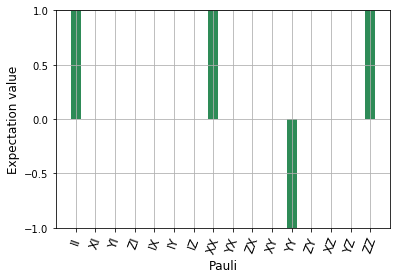

In [4]:
# plot the state
plot_state(rho,"paulivec")

We can compare the ideal entangled state to a non-entangled mixed state $\frac{1}{2}(|00\rangle\langle00| +|11\rangle\langle11|)$:

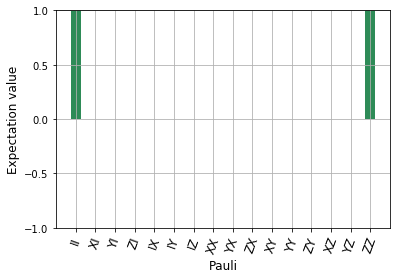

In [5]:
rho_mixed = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])/2
plot_state(rho_mixed,"paulivec")

### Building tomography measurement circuits

Next we must construct a family of circuits which implement a tomographically complete set of measurements of the qubit. The `statetomo.py` example library contains functions to generate these measurement circuits for general n-qubit systems. We do this by measuring in the X, Y, and Z for each qubit. This results in $3^n$ measurement circuits which must be executed to gather count statistics for the tomographic reconstruction.

The function to build the circuits is:
```python
tomo.build_state_tomography_circuits(QP, 'prep', qr, cr, qubits)
```
The function to construct an array of the the corresponding labels for these circuits is:
```python
tomo.state_tomography_labels('prep', qubits)
```
where 
- `QP` is the quantum program.
- `'prep'` is the name of the preparation circuit    
- `'qr'` is the name of the quantum registers to be measured
- `'cr'` is the name of the classical registers to store outcomes
- `qubits` is a list of the qubits to be measured. Eg `[i,j]` for `qr[i]`, and `qr[j]`.

In [6]:
# Qubits being measured
meas_qubits = [0,1]
# Construct the state tomography measurement circuits in QP
tomo_labels = tomo.build_state_tomography_circuits(Q_program, "bell", meas_qubits, qr, cr)
print(tomo_labels)


>> created state tomography circuits for "bell"
['bell_measX0X1', 'bell_measX0Y1', 'bell_measX0Z1', 'bell_measY0X1', 'bell_measY0Y1', 'bell_measY0Z1', 'bell_measZ0X1', 'bell_measZ0Y1', 'bell_measZ0Z1']


### Testing experiments on a simulator

Now that we have prepared the required circuits for state preparation and measurement, we should test them on a simulator before trying to run them on the real device.

We specify the device, and a number of experiment shots to perform to gather measurement statistics. The larger the number of shots, the more accurate our measurmeent probabilities will be compared to the *true* value.

In [7]:
# Use the local simulator
backend = 'local_qasm_simulator'

# Take 1000 shots for each measurement basis
shots = 5000

# Run the simulation
result = Q_program.execute(tomo_labels, backend=backend, shots=shots)
print(result)

{'status': 'COMPLETED', 'result': 'all done'}


Before doing the tomographic reconstruction we can view the count statistics from the simulation:

In [8]:
bell_tomo_dat = tomo.state_tomography_data(Q_program, 'bell', meas_qubits)
print(bell_tomo_dat)

[{'counts': {'00': 2566, '01': 0, '10': 0, '11': 2434}, 'meas_basis': {'00': array([[ 0.25,  0.25,  0.25,  0.25],
       [ 0.25,  0.25,  0.25,  0.25],
       [ 0.25,  0.25,  0.25,  0.25],
       [ 0.25,  0.25,  0.25,  0.25]]), '01': array([[ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25]]), '10': array([[ 0.25,  0.25, -0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25,  0.25],
       [-0.25, -0.25,  0.25,  0.25]]), '11': array([[ 0.25, -0.25, -0.25,  0.25],
       [-0.25,  0.25,  0.25, -0.25],
       [-0.25,  0.25,  0.25, -0.25],
       [ 0.25, -0.25, -0.25,  0.25]])}, 'shots': 5000}, {'counts': {'00': 1285, '01': 1195, '10': 1281, '11': 1239}, 'meas_basis': {'00': array([[ 0.25+0.j  ,  0.00-0.25j,  0.25+0.j  ,  0.00-0.25j],
       [ 0.00+0.25j,  0.25+0.j  ,  0.00+0.25j,  0.25+0.j  ],
       [ 0.25+0.j  ,  0.00-0.25j,  0.25+0.j  ,  0.00-0.25j],
       [ 0.00+0.25j,  0

### Reconstructing state from count data

To reconstruct the maximum likelihod estimate of the measured quantum state we use the following function:
```
fit_state(tomo_data, method, options)
```
where
- `QP` is the quantum program containing the measurement results
- `circuits` is the array of tomographic measurement circuits measured
- `shots` is the total number of shots for each measurement circuit
- `total_qubits` is the total number of qubits in the system (the length of shot outcome bitstrings)
- `meas_qubits` is an array of the measurement qubit indices

In [9]:
rho_fit = tomo.fit_state(bell_tomo_dat, method='wizard')

We can compare the reconstructed state to the target state vector. We use the Fidelity function, which for a comparing a density matrix $\rho$ to a pure state $|\psi\rangle$ is given by $F = \sqrt{\langle \psi| \rho |\psi\rangle}$. This may be done by the function **`state_fidelity`** from the **`qiskit.tools.qi`** module.

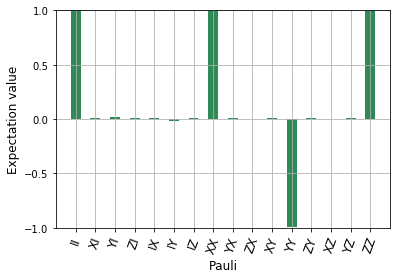

Fidelity with ideal state
F = 0.998605845949
concurrence =  0.867947271153
purity =  0.994921709957


In [10]:
# target state is (|00>+|11>)/sqrt(2)
target = np.array([1., 0., 0., 1.]/np.sqrt(2.))

# calculate fidelity
F_fit = state_fidelity(rho_fit, [0.707107, 0, 0, 0.707107])
plot_state(rho_fit, 'paulivec')
print("Fidelity with ideal state")
print("F =", F_fit)

# calculate concurrence and purity
con = concurrence(rho_fit)
pur = purity(rho_fit)
print("concurrence = ", str(con))
print("purity = ", str(pur))

Note that since our simulator is *perfect* the output state should be *exactly* the Bell-state, so we should obtain F = 1. Why is it not in our case? Since we can never directly *see* the final state we must obtain information about it via measurements. We would only obtain the *true* probabilities for the state in the limit of infinite measurement shots. Hence we have statistical error in our reconstruction due to having imperfect information about the state itself. Try running with different number of shots on the simulator and see how it effects the fidelity of the reconstruction.

### Running on a real device

Now that we've checked our simple tomography experiment worked, lets try it out on the IBM Quantum Experience! To do this we must have attached our API key, and it is good practice to set a limit on the number of credits to use:

In [11]:
# Use the IBM Quantum Experience
backend = 'ibmqx2'
# Take 1000 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 1000
# set max credits
max_credits = 5

# Run the simulation
result = Q_program.execute(tomo_labels, backend=backend, shots=shots, max_credits=max_credits, silent=False,wait=20, timeout=240)
print(result)

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
status = RUNNING (60 seconds)
status = RUNNING (80 seconds)
status = RUNNING (100 seconds)
status = RUNNING (120 seconds)
{'status': 'COMPLETED', 'result': 'all done'}


As before we can check our results, and check our tomographically reconstructed state.

In [12]:
bell_tomo_qx = tomo.state_tomography_data(Q_program, 'bell', meas_qubits)

Notice that for measurement results the bitstrings are now actually those for 5 qubits, even though we only measured one. This is because the QX is a 5-qubit quantum processor. To reconstruct the single qubit state from these results we use `total_qubits=5`. Note also that the qubit ordering in this bitstrings is `q[4]q[3]q[2]q[1]q[0]`

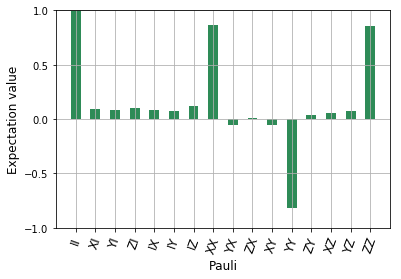

Fidelity with ideal state
F = 0.940571496123
concurrence =  0.607953953656
purity =  0.803925932438


In [14]:
rho_fit_real = tomo.fit_state(bell_tomo_qx, method='wizard')
# target state is (|00>+|11>)/sqrt(2)
target = np.array([1., 0., 0., 1.]/np.sqrt(2.))

F_fit_real = state_fidelity(rho_fit_real, [0.707107, 0, 0, 0.707107])
plot_state(rho_fit_real, 'paulivec')
print("Fidelity with ideal state")
print("F =", F_fit_real)

# calculate concurrence and purity
con = concurrence(rho_fit_real)
pur = purity(rho_fit_real)
print("concurrence = ", str(con))
print("purity = ", str(pur))